In [9]:
import pandas as pd
import sqlite3 as s3
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [10]:
def run_query(q):
    with s3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with s3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = """SELECT
                name,
                type
        FROM sqlite_master
        WHERE type IN ("table","view");"""
    return run_query(q)


show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


---------------------------------
## Case Study 1
--------------------------------
The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four.

|Artist Name	|Genre|
|:---------------|:-----|
|Regal	|Hip-Hop|
|Red Tone	|Punk|
|Meteor and the Girls	|Pop|
|Slim Jim Bites	|Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [11]:
q = """WITH 
        US_track_sales AS
            (
             SELECT
                 il.track_id,
                 t.genre_id,
                 SUM(il.quantity) sale_per_track
             FROM invoice_line il
             INNER JOIN track t
             ON t.track_id = il.track_id
             INNER JOIN invoice i
             ON i.invoice_id = il.invoice_id
             GROUP BY t.track_id
             HAVING i.billing_country = 'USA'
             ),
        
        genre_sales AS
            (
             SELECT
                 g.name genre,
                 SUM(uts.sale_per_track) sale_per_genre
             FROM US_track_sales uts
             LEFT JOIN genre g
             ON g.genre_id = uts.genre_id
             GROUP BY uts.genre_id
            )
            
        SELECT
            gs.*,
            ROUND((gs.sale_per_genre/CAST((SELECT SUM(sale_per_genre) FROM genre_sales) AS FLOAT))*100, 2) "%_of_sale_per_genre"
        FROM genre_sales gs
        ORDER BY sale_per_genre DESC
         """

sales_per_genre = run_query(q)
sales_per_genre

,genre,sale_per_genre,%_of_sale_per_genre
0,Rock,588,51.17
1,Metal,175,15.23
2,Alternative & Punk,133,11.58
3,Pop,49,4.26
4,R&B/Soul,49,4.26
5,Alternative,43,3.74
6,Jazz,20,1.74
7,Hip Hop/Rap,20,1.74
8,Easy Listening,19,1.65
9,Latin,17,1.48


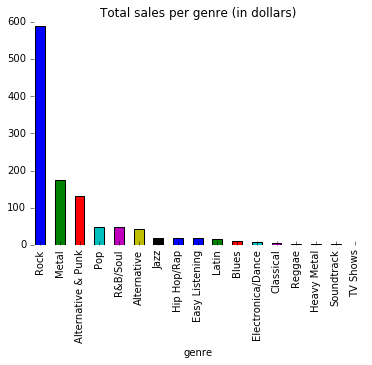

In [12]:
ax = sales_per_genre.plot.bar(x="genre", y="sale_per_genre", legend=False)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_title('Total sales per genre (in dollars)')

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

## Analysis
----------------------
### Recommendation of artists whose albums should be purchased

- Based on the sales per genre in US, we should consider to purchase below artist's albums ordered by rank
    + Red Tone
    + Meteor and the Girls
    + Regal

------------------------------------
## Case Study 2
------------------------------------
Analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others

In [13]:
q = """WITH
         total_sales AS
            (
             SELECT 
                c.support_rep_id, 
                SUM(i.total) total_sale_by_employee
             FROM customer c
             LEFT JOIN invoice i
             ON i.customer_id = c.customer_id
             GROUP BY c.support_rep_id
             )
          
         SELECT 
             ts.support_rep_id employee_id,
             e.first_name || ' ' || e.last_name employee_name,
             e.title,
             e.hire_date,
             e.city,
             e.state,
             e.country,
             ts.total_sale_by_employee
         FROM total_sales ts
         INNER JOIN employee e
         ON e.employee_id = ts.support_rep_id
         ORDER BY ts.total_sale_by_employee DESC
         
        """
        
total_sales_by_agent = run_query(q)
total_sales_by_agent

,employee_id,employee_name,title,hire_date,city,state,country,total_sale_by_employee
0,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,Calgary,AB,Canada,1731.51
1,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,Calgary,AB,Canada,1584.00
2,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,Calgary,AB,Canada,1393.92


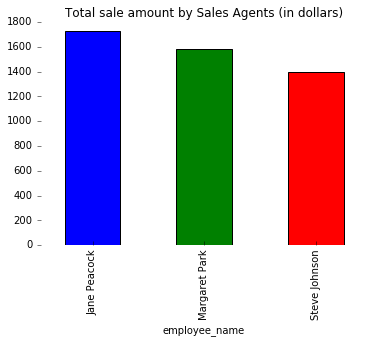

In [14]:
ax = total_sales_by_agent.plot.bar(x="employee_name", y="total_sale_by_employee", legend=False)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_title('Total sale amount by Sales Agents (in dollars)')

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

## Analysis
-----------------------
### Result description and Interpretation on total sales by sales agent

- All sales agents belong to same city of Canada.
- Though there is no major variance in terms of total sales by each agent but the slight margin of difference can be accounted to their tenure in the company.
- If we look into hire_date of each agent we can see that the one who joined earlier made the highest amount of sales and this trend continues with others who joined later

------------------------------------
## Case Study 3
------------------------------------
Analyze the sales data for customers from each different country

In [15]:
q = '''
WITH
    sales_per_customer AS
    (
    SELECT
        customer_id, 
        COUNT(invoice_id) total_orders_by_cust, 
        SUM(total) total_sale_by_cust
        FROM invoice
        GROUP BY customer_id
    ),
    sales_per_country AS
    (
    SELECT
        c.country,
        COUNT(c.customer_id) no_of_customers,
        SUM(spc.total_orders_by_cust) no_of_orders,
        SUM(spc.total_sale_by_cust) total_sale_amount
        FROM customer c
        INNER JOIN sales_per_customer spc
        ON spc.customer_id = c.customer_id
        GROUP BY c.country
     ),
    sales_per_grouped_country AS
    (  
    SELECT
         CASE
             WHEN sc.no_of_customers > 1 THEN sc.country
             ELSE "Other"
         END AS country_name,
         sc.no_of_customers,
         sc.no_of_orders,
         sc.total_sale_amount
    FROM sales_per_country sc
    )
    
SELECT
    spgc1.country_name,
    spgc1.no_of_customers,
    spgc1.no_of_orders,
    spgc1.total_sale_amount,
    spgc1.avg_val_of_sales_per_cust,
    spgc1.average_order_value
    FROM
    (
    SELECT
        spgc.country_name,
        CAST(SUM(spgc.no_of_customers) AS int) no_of_customers,
        CAST(SUM(spgc.no_of_orders) AS int) no_of_orders,
        CAST(SUM(spgc.total_sale_amount) AS float) total_sale_amount,
        ROUND(CAST(SUM(spgc.total_sale_amount) AS float)/SUM(spgc.no_of_customers), 2) avg_val_of_sales_per_cust,
        ROUND(CAST(SUM(spgc.total_sale_amount) AS float)/SUM(spgc.no_of_orders), 2) average_order_value,
        CASE
            WHEN spgc.country_name = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM sales_per_grouped_country spgc
    GROUP BY spgc.country_name
    ) spgc1
    ORDER BY sort, spgc1.total_sale_amount DESC
                  
'''
sales_data_per_country = run_query(q)
sales_data_per_country.set_index('country_name', drop=True, inplace=True)
sales_data_per_country

,no_of_customers,no_of_orders,total_sale_amount,avg_val_of_sales_per_cust,average_order_value
country_name,,,,,
USA,13,131,1040.49,80.04,7.94
Canada,8,76,535.59,66.95,7.05
Brazil,5,61,427.68,85.54,7.01
France,5,50,389.07,77.81,7.78
Germany,4,41,334.62,83.66,8.16
Czech Republic,2,30,273.24,136.62,9.11
United Kingdom,3,28,245.52,81.84,8.77
Portugal,2,29,185.13,92.56,6.38
India,2,21,183.15,91.57,8.72


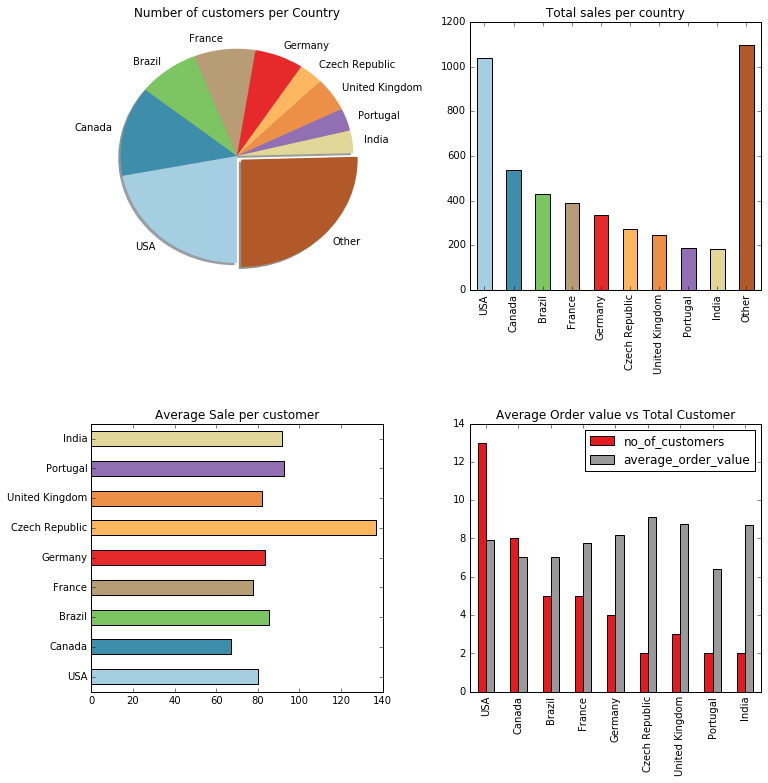

In [16]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))
fig.subplots_adjust(hspace=.5, wspace=.3)

colors = [plt.cm.Paired(i) for i in np.linspace(0, 1, sales_data_per_country.shape[0])]

#ax1-Top left
no_of_cust = sales_data_per_country['no_of_customers']

no_of_cust.plot.pie(ax=ax1, 
                    title='Number of customers per Country',
                    explode=(0,0,0,0,0,0,0,0,0,0.05),
                    colormap=plt.cm.Paired,
                    wedgeprops={'linewidth':0},
                    shadow=True,
                    counterclock=False,
                    startangle=270
                    )
ax1.set_ylabel('')

#ax1-Top left
total_sale = sales_data_per_country['total_sale_amount']

total_sale.plot.bar(ax=ax2,
                    title='Total sales per country',
                    color=colors
                    )
ax2.set_xlabel('')

#ax3-Bottem left
Avg_sale_per_cust = sales_data_per_country['avg_val_of_sales_per_cust'][0:len(sales_data_per_country)-1]

Avg_sale_per_cust.plot.barh(ax=ax3,
                            title="Average Sale per customer",
                            color=colors
                           )
ax3.set_ylabel('')

#ax4-Bottom right
Avr_ord_val_vs_no_cust = sales_data_per_country[['no_of_customers','average_order_value']][0:len(sales_data_per_country)-1]

Avr_ord_val_vs_no_cust.plot.bar(ax=ax4,
                                title="Average Order value vs Total Customer",
                                colormap=plt.cm.Set1
                               )
ax4.set_xlabel('')

## Analysis
-----------------------
### Result description on Sales data and recommendations on potential markets for growth

- India, Portugal and Czech Republic have low number of customers but their average sale value in total is greater than other markets.
- Hence these three markets can be looked into by the marketing team for potential growth.

------------------------------------
## Case Study 4
------------------------------------
Analyze if cutomers are purchasing individual tracks or entire albums. This study will help company to come up with better/new purchasing strategy.

In [48]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


## Analysis
-----------------------
### Recommendation on whether the Chinook store should continue to buy full albums from record companies

- Since 18.5% of the sales come from full album purchases, its not recommended to discontinue purchasing full albums by Chinook store from record companies.